# Code für Bachelor Thesis

In [1]:
from google.cloud import bigquery
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import numpy as np
import datetime
import matplotlib.dates as dt
import matplotlib.patches as mpatches

In [2]:
%%capture
client = bigquery.Client(project='api-project-764811344545')

https://s3-us-west-2.amazonaws.com/unpaywall-data-snapshots

In [3]:
unpaywall_snapshots = {
    # 2018-03-29
    'mar18': ['`oadoi_full.upw_Mar18_08_20`'],
    
    # 2018-04-28
    'apr18': ['`oadoi_full.upw_Apr18_08_20`'],
    
    # 2018-06-21
    'jun18': ['`oadoi_full.upw_Jun18_08_20`'],
    
    # 2018-09-27
    'sep18': ['`oadoi_full.upw_Sep18_08_20`'],
    
    # 2019-02-21
    'feb19': ['`oadoi_full.feb_19_mongo_export_2008_2012_full_all_genres`',
              '`oadoi_full.feb_19_mongo_export_2013_Feb2019_full_all_genres`'],

    # 2019-04-20
    'apr19': ['`oadoi_full.mongo_export_apr19_2008_2012_full_macos`',
              '`oadoi_full.mongo_export_apr19_2013_Apr2019_full_macos`'],
    
    # 2019-08-16
    'aug19': ['`oadoi_full.upw_Aug19_08_20`'],

    # 2019-11-22
    'nov19': ['`oadoi_full.mongo_export_upwNov19_08_12`',
              '`oadoi_full.mongo_export_upwNov19_13_19`'],

    # 2020-02-25
    'feb20': ['`oadoi_full.mongo_upwFeb20_08_12`',
              '`oadoi_full.mongo_upwFeb20_13_20`'],
    
    # 2020-04-27
    'apr20': ['`oadoi_full.upw_Apr20_08_20`'],
    
    # 2020-10-09
    'oct20': ['`oadoi_full.upw_Oct20_08_20`'],
}

In [4]:
snapshot_dates = {
    'mar18': [2018, 3], 
    'apr18': [2018, 4], 
    'jun18': [2018, 6], 
    'sep18': [2018, 9], 
    'feb19': [2019, 2], 
    'apr19': [2019, 4], 
    'aug19': [2019, 8], 
    'nov19': [2019, 11], 
    'feb20': [2020, 2], 
    'apr20': [2020, 4],
    'oct20': [2020, 10]
}

## Datenschema

https://unpaywall.org/data-format

In [5]:
schemas = [s for s in os.listdir('schemas') if s.endswith('.json')]

In [6]:
order = ['mar18', 'apr18', 'jun18', 'sep18', 'feb19', 'apr19', 'aug19', 
         'nov19', 'feb20', 'apr20', 'oct20']
schemas = [s for i in order for s in schemas if s[:-5] == i]

In [7]:
df_schema = pd.DataFrame()

for snapshot_json in schemas:
    with open('schemas/' + snapshot_json, 'r') as file:
        data = file.read()
        schema = json.loads(data)
        df2 = pd.json_normalize(schema)
        df2 = pd.DataFrame(df2.columns, columns=['column_name'])
        
        df2.rename(columns={'column_name': 'metadata_field'}, inplace=True)
        
        snapshot = snapshot_json[:-5]
        
        df2['snapshot'] = snapshot
        df2['snapshot_timestamp'] = datetime.datetime(snapshot_dates[snapshot][0],
                                                      snapshot_dates[snapshot][1],
                                                      1)
        
        i = order.index(snapshot)
        
        if order[i] == order [-1]:
            df2['next_snapshot'] = datetime.datetime(2021, 2, 1)
        else:
            df2['next_snapshot'] = datetime.datetime(snapshot_dates[order[i+1]][0],
                                                     snapshot_dates[order[i+1]][1],
                                                     1)
            
        df2['metadata_field'] = df2['metadata_field'].str.replace('^oa_locations$', 'best_oa_location', regex=True)
        df2['metadata_field'] = df2['metadata_field'].str.replace('^best_oa_location.',
                                                                  'oa_locations.', regex=True)
        df2['metadata_field'] = df2['metadata_field'].replace('^first_oa_location.*', 
                                                              'first_oa_location', regex=True)
        
        df_schema = df_schema.append(df2, ignore_index=True)

In [8]:
df_schema.groupby(['snapshot'], sort=False)['metadata_field'].nunique().reset_index()

,snapshot,metadata_field
0,mar18,27
1,apr18,27
2,jun18,26
3,sep18,26
4,feb19,27
5,apr19,28
6,aug19,30
7,nov19,31
8,feb20,32
9,apr20,32


In [9]:
df_schema_list = df_schema.groupby(['metadata_field'])['snapshot'].apply(set).reset_index()
df_schema_list['length'] = df_schema_list['snapshot'].str.len()
df_schema_list.sort_values(by='length', ascending=True, inplace=True)
df_schema_list = df_schema_list[['metadata_field', 'length']]

In [10]:
df_schema_l = df_schema.merge(df_schema_list, on='metadata_field', how='left')
df_schema_l.sort_values(by='length', ascending=False, inplace=True)

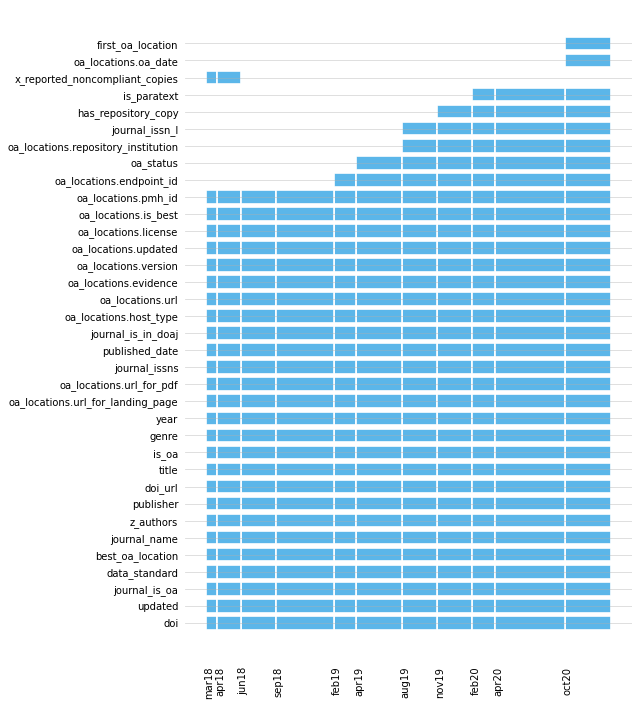

In [11]:
fig, ax = plt.subplots(figsize=(8,12)) 

yticks = []
yticklabels = []
ypos = {}
y = 0

xticks = []
xticklabels = []
xpos = {}

for idx, row in df_schema_l.iterrows():
    
    if row['metadata_field'] not in yticklabels:
        y += 10
        ypos[row['metadata_field']] = y
        
        yticks.append(ypos[row['metadata_field']])
        yticklabels.append(row['metadata_field'])
        
    if row['snapshot'] not in xticklabels:
        xpos[row['snapshot_timestamp']] = row['snapshot_timestamp'] + datetime.timedelta(days=8)
        
        xticks.append(xpos[row['snapshot_timestamp']])
        xticklabels.append(row['snapshot'])

    ax.broken_barh([(row['snapshot_timestamp'], 
                     row['next_snapshot'] - row['snapshot_timestamp'])], 
                   (ypos[row['metadata_field']]-4, 8), 
                   alpha=0.97,
                   linewidth=1.7,
                   facecolors=('#56B4E9'),
                   edgecolors=('#FFFFFF')) 
    
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

ax.set_frame_on(False)
ax.grid(False, which='both', axis='x')
ax.grid(True, which='both', axis='y', alpha=0.5)

ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none')

plt.xticks(rotation=90)

plt.show()

fig.savefig('media/schema.png', format='png', bbox_inches='tight', dpi=500)

Probleme mit dem September 2018 Snapshot: https://groups.google.com/forum/#!topic/unpaywall/kPdWDvaF9IA

## Datenvolumen

In [12]:
df_volume = pd.DataFrame()

for snapshot in unpaywall_snapshots:
    if snapshot in ['feb20', 'apr20', 'oct20']: 
        is_paratext = 'AND is_paratext=false'
    else:
        is_paratext = ''
    for snapshot_name in unpaywall_snapshots[snapshot]:
        df2 = client.query(f"""
                           SELECT COUNT(DISTINCT(doi)) AS n, year 
                           FROM {snapshot_name} 
                           WHERE year<2019 AND genre="journal-article" {is_paratext}
                           GROUP BY year
                           """).to_dataframe()

        df2['snapshot'] = snapshot

        df_volume = df_volume.append(df2, ignore_index=True)

In [13]:
df_volume.groupby(['snapshot'], sort=False)['n'].sum().reset_index()

,snapshot,n
0,mar18,27498666
1,apr18,27268179
2,jun18,28201468
3,sep18,29908032
4,feb19,31159960
5,apr19,31341794
6,aug19,31602128
7,nov19,31827129
8,feb20,31611299
9,apr20,31482103


## is_oa

In [14]:
df = pd.DataFrame()

for snapshot in unpaywall_snapshots:
    if snapshot in ['feb20', 'apr20', 'oct20']: 
        is_paratext = 'AND is_paratext=false'
    else:
        is_paratext = ''
    for snapshot_name in unpaywall_snapshots[snapshot]:
        df2 = client.query(f"""
                           SELECT year, is_oa, COUNT(DISTINCT(doi)) AS n 
                           FROM {snapshot_name} 
                           WHERE year<2019 AND genre="journal-article" {is_paratext}
                           GROUP BY year, is_oa
                           """).to_dataframe()

        df2['snapshot'] = snapshot

        df = df.append(df2, ignore_index=True)

In [15]:
df['prop'] = df.groupby(['year', 'snapshot'])['n'].transform(lambda x: x / x.sum())
df.prop = df.prop.apply(lambda x: '{0:.2f}'.format(x))
df = df.sort_values(by=['year', 'is_oa'], ascending=[True, False]).reset_index(drop=True)

In [16]:
df_oa = df.copy()
df_oa = df_oa.groupby(['snapshot', 'is_oa'])['n'].sum().reset_index()

In [17]:
df_oa['prop'] = df_oa.groupby(['snapshot'])['n'].transform(lambda x: x / x.sum())

In [18]:
df_oa[df_oa.is_oa==True]

,snapshot,is_oa,n,prop
1,apr18,True,8882945,0.325762
3,apr19,True,11944603,0.381108
5,apr20,True,13381079,0.425038
7,aug19,True,12247269,0.387546
9,feb19,True,11633886,0.373360
11,feb20,True,13527352,0.427928
13,jun18,True,10019685,0.355289
15,mar18,True,8679504,0.315634
17,nov19,True,13569137,0.426339
19,oct20,True,13776844,0.434427


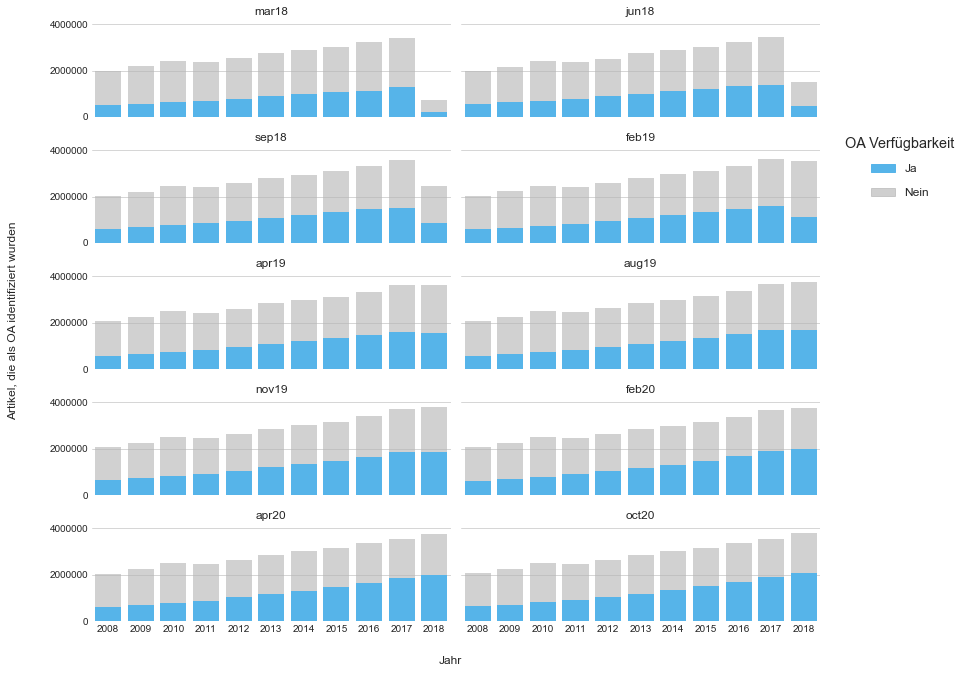

In [19]:
plt.style.use('seaborn-whitegrid')

palette = {True: '#56B4E9',
           False: '#b3b3b3a0'}

fig, axes = plt.subplots(nrows=5, 
                         ncols=2, 
                         sharex=True, 
                         sharey=True, 
                         figsize=(11, 9))

axes = axes.reshape(-1)

#ti = fig.suptitle('Unpaywall OA-Anteile per Snapshot', 
#                  fontsize=15, 
#                  fontweight=600, 
#                  x=0.53,
#                  y=1.0)

snapshot_list = list(unpaywall_snapshots.keys())
snapshot_list.remove('apr18')

df['n_sum'] = df.groupby(['year', 'snapshot'])['n'] \
                    .transform(lambda x: x.sum())

for i, ax in enumerate(axes, 1):
    
    snapshot = snapshot_list[i-1]
    
    df2 = df[df['snapshot']==snapshot]
    
    sns.barplot(data=df2, 
                x='year', 
                y='n_sum', 
                alpha=0.6,
                color='#b3b3b3a0',
                saturation=1,
                ci=None,
                ax=ax)
    
    sns.barplot(data=df2[df2.is_oa==True], 
                x='year', 
                y='n', 
                alpha=1,
                color='#56B4E9',
                saturation=1,
                ci=None,
                ax=ax)
    
    sns.despine(bottom = True, left = True)
    
    ax.set_ylabel('')    
    ax.set_xlabel('')
    
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
    
    ax.set_title(snapshot, fontdict={'fontsize': 12, 'fontweight': 500}, pad=9)
    
    ax.grid(False, which='both', axis='x')

# common xlabel   
x_label = fig.text(0.52, -0.03, 'Jahr', ha='center', 
                   fontdict={'fontsize': 12, 'fontweight': 500})

# common ylabel
y_label = fig.text(-0.04, 0.5, 'Artikel, die als OA identifiziert wurden', va='center', rotation='vertical', 
                   fontdict={'fontsize': 12, 'fontweight': 500})

is_oa_patch = mpatches.Patch(color='#56B4E9', label='Ja')
is_not_oa_patch = mpatches.Patch(color='#b3b3b3a0', label='Nein')
lgd = fig.legend(handles=[is_oa_patch, is_not_oa_patch], title='OA Verfügbarkeit', 
                 fontsize='large', title_fontsize='x-large', 
                 bbox_to_anchor=(1.17, 0.8), labelspacing=1.1)

plt.tight_layout()

plt.show()

fig.savefig('media/is_oa.png', format='png', 
            bbox_extra_artists=(lgd, x_label, y_label), bbox_inches='tight', dpi=500)

## Open Access Status

In [20]:
df = pd.DataFrame()

for snapshot in unpaywall_snapshots:
    if snapshot in ['mar18', 'apr18', 'jun18', 'sep18', 'feb19']:
        continue
    if snapshot in ['feb20', 'apr20', 'oct20']: 
        is_paratext = 'AND is_paratext=false'
    else:
        is_paratext = ''
    for snapshot_name in unpaywall_snapshots[snapshot]:
        df2 = client.query(f"""
                           SELECT year, oa_status, COUNT(DISTINCT(doi)) AS n 
                           FROM {snapshot_name}, UNNEST(oa_locations) 
                           WHERE year<2019 AND genre="journal-article" {is_paratext}
                           GROUP BY year, oa_status
                           """).to_dataframe()

        df2['snapshot'] = snapshot

        df = df.append(df2, ignore_index=True)

In [21]:
df['prop'] = df.groupby(['year', 'snapshot'])['n'].transform(lambda x: x / x.sum())
df = df.sort_values(by=['year', 'oa_status'], ascending=[True, False]).reset_index(drop=True)

In [22]:
df.head()

,year,oa_status,n,snapshot,prop
0,2008,hybrid,131012,apr19,0.228527
1,2008,hybrid,75323,aug19,0.131329
2,2008,hybrid,73740,nov19,0.114135
3,2008,hybrid,74177,feb20,0.120404
4,2008,hybrid,49155,apr20,0.082226


In [23]:
df_oa_status = df.copy()
df_oa_status.dropna(inplace=True)

In [24]:
df_oa_status[df_oa_status.snapshot=='apr19'].groupby(['oa_status'])['n'].sum()

oa_status
bronze    4452702
gold       818508
green     2111792
hybrid    4561113
Name: n, dtype: int64

In [25]:
df_oa_status[df_oa_status.snapshot=='apr19']['n'].sum()

11944115

In [26]:
4452702/11944115

0.37279463568460286

In [27]:
df_oa_status[df_oa_status.snapshot=='oct20'].groupby(['oa_status'])['n'].sum()

oa_status
bronze    4128706
gold      5251173
green     3031754
hybrid    1365211
Name: n, dtype: int64

In [28]:
df_oa_status[df_oa_status.snapshot=='oct20']['n'].sum()

13776844

In [29]:
4128706/13776844

0.299684456033617

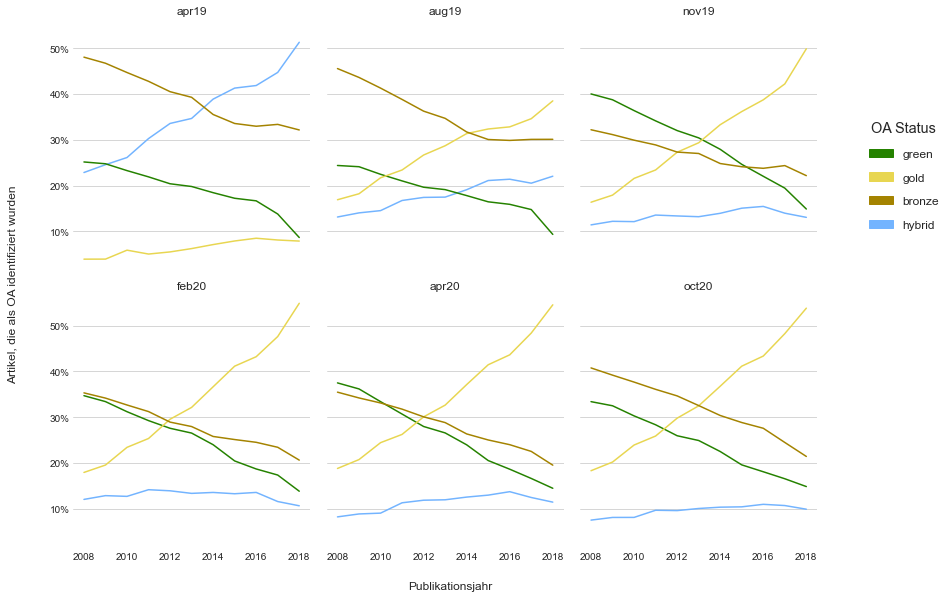

In [30]:
plt.style.use('seaborn-whitegrid')

palette = {'bronze': '#a48300',
           'gold': '#e8d651',
           'hybrid': '#73b4ff',
           'green': '#258200',
           'closed': '#410c4c'}

fig, axes = plt.subplots(nrows=2, 
                         ncols=3, 
                         sharex=True, 
                         sharey=True, 
                         figsize=(11, 8))

axes = axes.reshape(-1)

#ti = fig.suptitle('Unpaywall Open Access Status per Snapshot', 
#                  fontsize=15, 
#                  fontweight=600, 
#                  x=0.53,
#                  y=1.0)

for i, ax in enumerate(axes, 1):
    
    snapshot = df.snapshot.unique()[i-1]
    
    sns.lineplot(data=df[df['snapshot']==snapshot], 
                 x='year', 
                 y='prop', 
                 hue='oa_status',
                 palette=palette, 
                 ax=ax)
    
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    ax.get_legend().remove()
    sns.despine(bottom = True, left = True)
    
    ax.set_ylabel('')    
    ax.set_xlabel('')
    
    ax.set_title(snapshot, fontdict={'fontsize': 12, 'fontweight': 500}, pad=-0.1)
    
    ax.grid(False, which='both', axis='x')
    
# common xlabel   
x_label = fig.text(0.52, -0.03, 'Publikationsjahr', ha='center', 
                   fontdict={'fontsize': 12, 'fontweight': 500})

# common ylabel
y_label = fig.text(-0.04, 0.5, 'Artikel, die als OA identifiziert wurden', va='center', rotation='vertical', 
                   fontdict={'fontsize': 12, 'fontweight': 500})

green_oa_patch = mpatches.Patch(color='#258200', label='green')
gold_oa_patch = mpatches.Patch(color='#e8d651', label='gold')
bronze_oa_patch = mpatches.Patch(color='#a48300', label='bronze')
hybrid_oa_patch = mpatches.Patch(color='#73b4ff', label='hybrid')
lgd = fig.legend(handles=[green_oa_patch, gold_oa_patch, bronze_oa_patch, hybrid_oa_patch], title='OA Status', 
                 fontsize='large', title_fontsize='x-large', 
                 bbox_to_anchor=(1.15, 0.8), labelspacing=1.1)

plt.tight_layout()

plt.show()

fig.savefig('media/oa_status.png', format='png', 
            bbox_extra_artists=(lgd, x_label, y_label), bbox_inches='tight', dpi=500)

## Publisher

In [31]:
df_publisher = pd.DataFrame()

for snapshot in unpaywall_snapshots:
    if snapshot in ['mar18', 'apr18', 'jun18', 'sep18', 'feb19']:
        continue
    if snapshot in ['feb20', 'apr20', 'oct20']: 
        is_paratext = 'AND is_paratext=false'
    else:
        is_paratext = ''
    for snapshot_name in unpaywall_snapshots[snapshot]:
        df2 = client.query(f"""
                           SELECT publisher, oa_status, COUNT(DISTINCT(doi)) AS n 
                           FROM {snapshot_name}, UNNEST(oa_locations) 
                           WHERE year<2019 AND genre="journal-article" {is_paratext}
                           GROUP BY publisher, oa_status
                           """).to_dataframe()

        df2['snapshot'] = snapshot

        df_publisher = df_publisher.append(df2, ignore_index=True)

In [32]:
df_publisher.groupby(['publisher'])['n'].sum().reset_index().sort_values(by='n', ascending=False).head(10)

,publisher,n
2405,Elsevier BV,9303973
9221,Springer Nature,4384699
7131,Oxford University Press (OUP),2868526
9224,Springer Science and Business Media LLC,2471162
11678,Wiley-Blackwell,2193489
3719,Informa UK Limited,1723439
11677,Wiley,1488665
7618,Public Library of Science (PLoS),1460791
3559,IOP Publishing,1391353
2872,FapUNIFESP (SciELO),1264529


## Overlap Host Types

In [33]:
df_host_types = pd.DataFrame()

for snapshot in unpaywall_snapshots:
    if snapshot in ['feb20', 'apr20', 'oct20']: 
        is_paratext = 'AND is_paratext=false'
    else:
        is_paratext = ''
    for snapshot_name in unpaywall_snapshots[snapshot]:
        df2 = client.query(f"""
                            SELECT year, host_type_count, 
                               COUNT(DISTINCT(doi)) AS number_of_articles 
                            FROM 
                                (SELECT doi, year, 
                                STRING_AGG(DISTINCT(host_type) 
                                ORDER BY host_type) AS host_type_count
                                FROM {snapshot_name}, UNNEST (oa_locations) 
                                WHERE genre="journal-article" AND year < 2019 {is_paratext}
                                GROUP BY doi, year) 
                            GROUP BY host_type_count, year 
                            ORDER BY number_of_articles DESC
                           """).to_dataframe()

        df2['snapshot'] = snapshot
        
        df_host_types = df_host_types.append(df2, ignore_index=True)

In [34]:
df_host_types \
    .loc[df_host_types['host_type_count'] == 'publisher', 'host'] = 'nur Verlage'
df_host_types \
    .loc[df_host_types['host_type_count'] == 'publisher,repository', 
         'host'] = 'Verlage & Repositorien'
df_host_types \
    .loc[df_host_types['host_type_count'] == 'repository', 
         'host'] = 'nur Repositorien'

In [35]:
host_type_intersect_df = pd.merge(df_oa[df_oa.is_oa==True], 
                                  df_host_types, on=['snapshot'], how='right')

t = host_type_intersect_df.groupby(['snapshot', 'host', 'n'])['number_of_articles'].sum().reset_index()
t.groupby(['snapshot', 'host']).sum().eval('prop = number_of_articles/n').reset_index()

,snapshot,host,n,number_of_articles,prop
0,apr18,Verlage & Repositorien,8882945,2498103,0.281225
1,apr18,nur Repositorien,8882945,1758677,0.197984
2,apr18,nur Verlage,8882945,4626165,0.520792
3,apr19,Verlage & Repositorien,11944603,3003557,0.251457
4,apr19,nur Repositorien,11944603,2111850,0.176804
5,apr19,nur Verlage,11944603,6829196,0.571739
6,apr20,Verlage & Repositorien,13381079,5133575,0.383644
7,apr20,nur Repositorien,13381079,3107249,0.232212
8,apr20,nur Verlage,13381079,5140255,0.384144
9,aug19,Verlage & Repositorien,12247269,3285180,0.268238


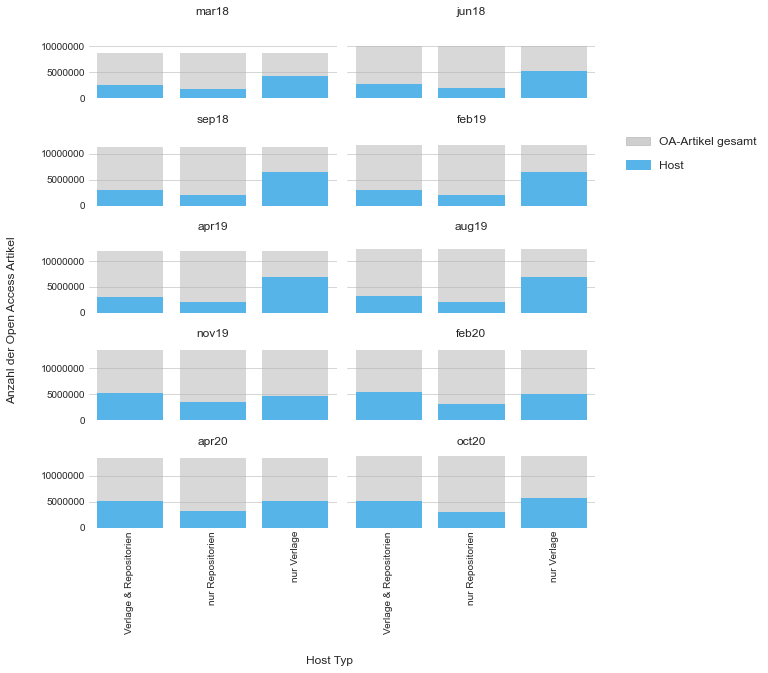

In [36]:
plt.style.use('seaborn-whitegrid')

fig, axes = plt.subplots(nrows=5, 
                         ncols=2, 
                         sharex=True, 
                         sharey=True, 
                         figsize=(8, 9))

axes = axes.reshape(-1)

#ti = fig.suptitle('Unpaywall Host Type', 
#                  fontsize=13, 
#                  fontweight=600, 
#                  x=0.53,
#                  y=0.99)

snapshot_list = list(unpaywall_snapshots.keys())
snapshot_list.remove('apr18')

for i, ax in enumerate(axes, 1):
    
    snapshot = snapshot_list[i-1]
    
    df2 = t[t['snapshot']==snapshot]
    
    sns.barplot(data=df2, 
                x='host', 
                y='n', 
                alpha=0.5,
                color='#b3b3b3a0',
                saturation=1,
                ci=None,
                ax=ax)
    
    sns.barplot(data=df2, 
                x='host', 
                y='number_of_articles', 
                alpha=1,
                color='#56B4E9',
                saturation=1,
                ci=None,
                ax=ax)
    
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
    
    sns.despine(bottom = True, left = True)
    
    ax.set_ylabel('')    
    ax.set_xlabel('')
    
    ax.set_title(snapshot, fontdict={'fontsize': 12, 'fontweight': 500}, pad=8)
    
    ax.grid(False, which='both', axis='x')
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

# common xlabel   
x_label = fig.text(0.52, -0.03, 'Host Typ', ha='center', 
                   fontdict={'fontsize': 12, 'fontweight': 500})

# common ylabel
y_label = fig.text(-0.04, 0.5, 'Anzahl der Open Access Artikel', va='center', 
                   rotation='vertical', fontdict={'fontsize': 12, 'fontweight': 500})

host_patch = mpatches.Patch(color='#56B4E9', label='Host')
not_host_patch = mpatches.Patch(color='#b3b3b3a0', label='OA-Artikel gesamt')
lgd = fig.legend(handles=[not_host_patch, host_patch], fontsize='large',
                 bbox_to_anchor=(1.28, 0.8), labelspacing=1.1)

plt.tight_layout()

plt.show()

fig.savefig('media/upw_host_type.png', format='png', 
            bbox_extra_artists=(x_label, y_label, lgd), bbox_inches='tight', dpi=500)

## Evidence Types

In [37]:
df_evidence = pd.DataFrame()

for snapshot in unpaywall_snapshots:
    if snapshot in ['feb20', 'apr20', 'oct20']: 
        is_paratext = 'AND is_paratext=false'
    else:
        is_paratext = ''
    for snapshot_name in unpaywall_snapshots[snapshot]:
        df2 = client.query(f"""
                           SELECT evidence, year, COUNT(DISTINCT(doi)) AS n
                           FROM {snapshot_name}, UNNEST (oa_locations)
                           WHERE year<2019 AND genre="journal-article" {is_paratext}
                           GROUP BY evidence, year
                           ORDER BY year
                           """).to_dataframe()

        df2['snapshot'] = snapshot
        
        df2['snapshot_timestamp'] = datetime.datetime(snapshot_dates[snapshot][0],
                                                      snapshot_dates[snapshot][1],
                                                      1)
        
        i = order.index(snapshot)
        
        if order[i] == order [-1]:
            df2['next_snapshot'] = datetime.datetime(2021, 2, 1)
        else:
            df2['next_snapshot'] = datetime.datetime(snapshot_dates[order[i+1]][0],
                                                     snapshot_dates[order[i+1]][1],
                                                     1)

        df_evidence = df_evidence.append(df2, ignore_index=True)

In [38]:
df_evidence2 = df_evidence.copy()

In [39]:
articles_per_type_df = df_evidence.groupby(['evidence'])['n'].sum().reset_index()

articles_per_type_df['prop'] = articles_per_type_df['n'] \
                                .transform(lambda x: 
                                           x / articles_per_type_df['n'] \
                                           .sum() * 100)

list_of_small_evidence_types = articles_per_type_df \
                                .loc[articles_per_type_df['prop'] < 1] \
                                .evidence.tolist()

df_evidence.evidence = df_evidence.evidence.replace(list_of_small_evidence_types, 'other')

df_evidence['prop'] = df_evidence['n'].transform(lambda x: x / df_evidence['n'].sum() * 100)

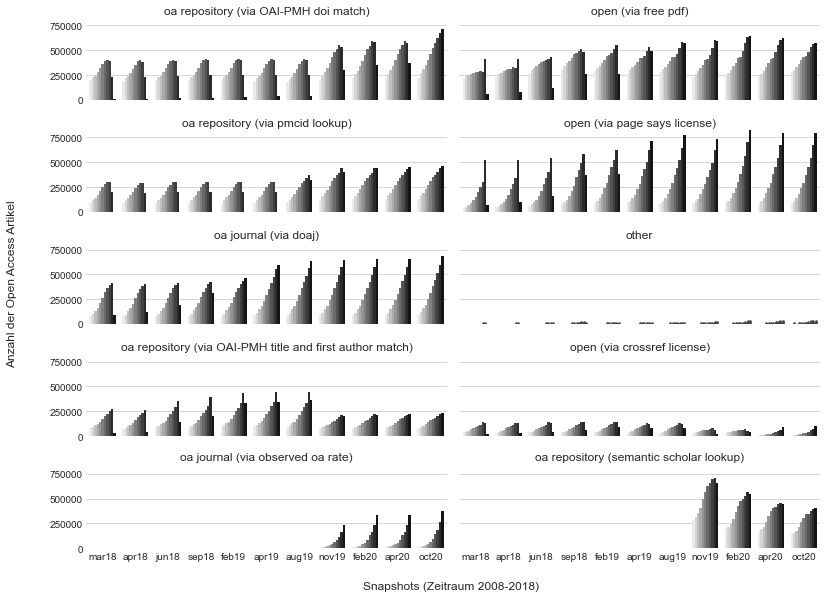

In [40]:
plt.style.use('seaborn-whitegrid')

fig, axes = plt.subplots(nrows=5, 
                         ncols=2, 
                         sharex=True, 
                         sharey=True, 
                         figsize=(11, 8))

axes = axes.reshape(-1)

#ti = fig.suptitle('Unpaywall Evidenztypen per Snapshot', 
#                  fontsize=15, 
#                  fontweight=600, 
#                  x=0.53,
#                  y=1.0)

for i, ax in enumerate(axes, 1):
    
    evidence = df_evidence.evidence.unique()[i-1]
    
    df2 = df_evidence[df_evidence['evidence']==evidence]
    
    for snapshot in unpaywall_snapshots.keys():
        if snapshot not in df2.snapshot.unique():
            for year in range(2008, 2019):
                data = dict(evidence=[evidence], year=[year], n=[0], snapshot=[snapshot], prop=[0.0])
                df3 = pd.DataFrame.from_dict(data)
                df2 = df2.append(df3, ignore_index=True)
                
    df2 = df2.set_index('snapshot').loc[list(unpaywall_snapshots.keys())].reset_index()
    
    sns.barplot(data=df2, 
                x='snapshot', 
                y='n', 
                hue='year',
                palette='binary',
                ax=ax)
    
    ax.get_legend().remove()
    sns.despine(bottom = True, left = True)
    
    ax.set_ylabel('')    
    ax.set_xlabel('')
    
    ax.set_title(evidence, fontdict={'fontsize': 12, 'fontweight': 500}, pad=-0.1)
    
    ax.grid(False, which='both', axis='x')

# common xlabel   
x_label = fig.text(0.52, -0.03, 'Snapshots (Zeitraum 2008-2018)', ha='center', 
                   fontdict={'fontsize': 12, 'fontweight': 500})

# common ylabel
y_label = fig.text(-0.04, 0.5, 'Anzahl der Open Access Artikel', va='center', rotation='vertical', 
                   fontdict={'fontsize': 12, 'fontweight': 500})

plt.tight_layout()

plt.show()

fig.savefig('media/evidence.png', format='png',
            bbox_extra_artists=(x_label, y_label), bbox_inches='tight', dpi=500)

In [41]:
df_evidence3 = df_evidence.copy()
df_evidence3 = df_evidence3[['evidence', 'n', 'snapshot']]

In [42]:
df_evidence3['prop'] = df_evidence3.groupby(['evidence'])['n'].transform(lambda x: x / df_evidence3.n.sum())
df_evidence3.groupby(['evidence'])['prop'].sum().reset_index()\
                                .sort_values(by=['prop'], ascending=False) \
                                .reset_index(drop=True)

,evidence,prop
0,open (via free pdf),0.191208
1,oa repository (via OAI-PMH doi match),0.166083
2,open (via page says license),0.148762
3,oa journal (via doaj),0.144481
4,oa repository (via pmcid lookup),0.117268
5,oa repository (via OAI-PMH title and first aut...,0.090439
6,oa repository (semantic scholar lookup),0.069821
7,open (via crossref license),0.034931
8,other,0.019528
9,oa journal (via observed oa rate),0.017478


In [43]:
df_evidence3['prop'] = df_evidence.groupby(['evidence', 'snapshot'])['n'] \
                                .transform(lambda x: x / df_evidence3.n.sum())

df_evidence3.groupby(['evidence', 'snapshot'])['prop'].sum().reset_index()\
                                .sort_values(by=['prop'], ascending=False) \
                                .reset_index(drop=True).head(10)

,evidence,snapshot,prop
0,oa repository (semantic scholar lookup),nov19,0.023835
1,oa repository (via OAI-PMH doi match),oct20,0.021224
2,open (via free pdf),feb20,0.019589
3,open (via free pdf),oct20,0.019485
4,open (via free pdf),aug19,0.019299
5,oa repository (via OAI-PMH doi match),apr20,0.019051
6,open (via free pdf),apr20,0.018951
7,oa repository (via OAI-PMH doi match),feb20,0.018793
8,open (via free pdf),sep18,0.018661
9,open (via free pdf),apr19,0.018422


In [44]:
df_evidence[df_evidence.snapshot=='oct20'].groupby(['evidence'])['n'].sum()

evidence
oa journal (via doaj)                                       3755942
oa journal (via observed oa rate)                           1237591
oa repository (semantic scholar lookup)                     3093537
oa repository (via OAI-PMH doi match)                       5128806
oa repository (via OAI-PMH title and first author match)    1726637
oa repository (via pmcid lookup)                            3343706
open (via crossref license)                                  419250
open (via free pdf)                                         4708652
open (via page says license)                                3900150
other                                                        673602
Name: n, dtype: int64

In [45]:
df_evidence[df_evidence.snapshot=='oct20'].n.sum()

27987873

In [46]:
3093537/27987873

0.11053133619693072

In [47]:
df_evidence_list = df_evidence2.groupby(['evidence'])['snapshot'].apply(set).reset_index()
df_evidence_list['length'] = df_evidence_list['snapshot'].str.len()
df_evidence_list.sort_values(by='length', ascending=True, inplace=True)
df_evidence_list = df_evidence_list[['evidence', 'length']]

In [48]:
df_evidence_l = df_evidence2.merge(df_evidence_list, on='evidence', how='left')
df_evidence_l.sort_values(by='length', ascending=False, inplace=True)

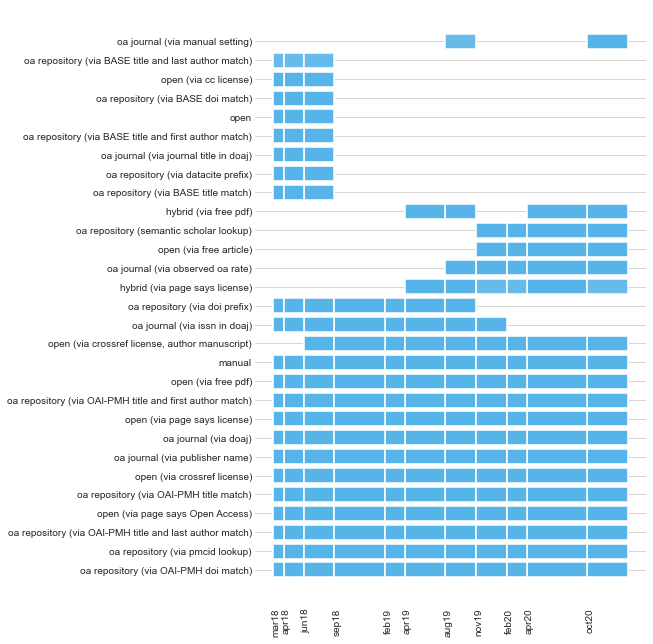

In [49]:
fig, ax = plt.subplots(figsize=(7,11)) 

yticks = []
yticklabels = []
ypos = {}
y = 0

xticks = []
xticklabels = []
xpos = {}

for idx, row in df_evidence_l.iterrows():
    
    if row['evidence'] not in yticklabels:
        y += 10
        ypos[row['evidence']] = y
        
        yticks.append(ypos[row['evidence']])
        yticklabels.append(row['evidence'])
        
    if row['snapshot'] not in xticklabels:
        xpos[row['snapshot_timestamp']] = row['snapshot_timestamp'] + datetime.timedelta(days=8)
        
        xticks.append(xpos[row['snapshot_timestamp']])
        xticklabels.append(row['snapshot'])

    ax.broken_barh([(row['snapshot_timestamp'], 
                     row['next_snapshot'] - row['snapshot_timestamp'])], 
                   (ypos[row['evidence']]-4, 8), 
                   alpha=0.9,
                   linewidth=1.7,
                   facecolors=('#56B4E9'),
                   edgecolors=('#FFFFFF')) 
    
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

ax.set_frame_on(False)
ax.grid(False, which='both', axis='x')

plt.xticks(rotation=90)

plt.show()

fig.savefig('media/evidence_all.png', bbox_inches='tight', dpi=500)

## Last Updated

In [50]:
df_updated = pd.DataFrame()

for snapshot in unpaywall_snapshots:
    updated_column = 'updated'
    if snapshot in ['mar18', 'apr18', 'jun18', 'aug19', 'apr20']:
        updated_column = 'TIMESTAMP(doi_updated)'
    if snapshot in ['sep18']:
        updated_column = 'TIMESTAMP(updated)'
    if snapshot in ['oct20']:
        updated_column = 'doi_updated'
    if snapshot in ['feb20', 'apr20', 'oct20']: 
        is_paratext = 'AND is_paratext=false'
    else:
        is_paratext = ''
    for snapshot_name in unpaywall_snapshots[snapshot]:
        df2 = client.query(f"""
                           SELECT EXTRACT(YEAR FROM {updated_column}) AS updated_year,
                               EXTRACT(MONTH FROM {updated_column}) AS updated_month,
                               COUNT(DISTINCT(doi)) AS n
                           FROM {snapshot_name}
                           WHERE year<2019 AND genre="journal-article" {is_paratext}
                           GROUP BY updated_year, updated_month
                           """).to_dataframe()

        df2['snapshot'] = snapshot
        df2['snapshot_year'], df2['snapshot_month'] = snapshot_dates[snapshot]

        df_updated = df_updated.append(df2, ignore_index=True)

In [51]:
df_updated = df_updated[df_updated.updated_year > 2006]
df_updated = df_updated.groupby(['updated_year', 
                                 'updated_month',
                                 'snapshot_year',
                                 'snapshot_month',
                                 'snapshot'])['n'] \
                    .sum().reset_index()

In [52]:
df_updated

,updated_year,updated_month,snapshot_year,snapshot_month,snapshot,n
0,2017,11,2018,3,mar18,31055
1,2017,11,2018,4,apr18,31012
2,2017,11,2018,6,jun18,94
3,2017,11,2018,9,sep18,69
4,2017,11,2019,2,feb19,71
...,...,...,...,...,...,...
120,2020,6,2020,10,oct20,464
121,2020,7,2020,10,oct20,380
122,2020,8,2020,10,oct20,1007
123,2020,9,2020,10,oct20,31438872


In [53]:
df_updated2 = df_updated.groupby(['updated_year', 'snapshot'])['n'].sum().reset_index()

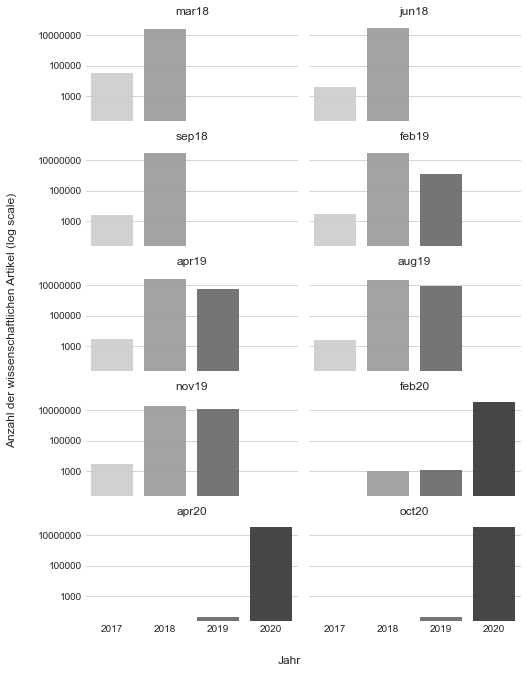

In [54]:
plt.style.use('seaborn-whitegrid')

fig, axes = plt.subplots(nrows=5, 
                         ncols=2, 
                         sharex=True, 
                         sharey=True, 
                         figsize=(7, 9))

axes = axes.reshape(-1)

#ti = fig.suptitle('Unpaywall Aktualisierungen per Snapshot', 
#                  fontsize=13, 
#                  fontweight=600, 
#                  x=0.53,
#                  y=1.0)

snapshot_list = list(unpaywall_snapshots.keys())
snapshot_list.remove('apr18')

for i, ax in enumerate(axes, 1):
    
    snapshot = snapshot_list[i-1]
    
    df2 = df_updated2[df_updated2['snapshot']==snapshot]
    
    for year in range(2017, 2021):
        if year not in df2.updated_year.unique():
            data = dict(snapshot=[snapshot], updated_year=[year], n=[0])
            df3 = pd.DataFrame.from_dict(data)
            df2 = df2.append(df3, ignore_index=True)
    
    sns.barplot(data=df2, 
                x='updated_year', 
                y='n', 
                alpha=0.9,
                palette='binary',
                saturation=1,
                ci=None,
                ax=ax)
    
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
    
    sns.despine(bottom = True, left = True)
    
    ax.set_ylabel('')    
    ax.set_xlabel('')
    
    ax.set_title(snapshot, fontdict={'fontsize': 12, 'fontweight': 500}, pad=8)
    
    ax.grid(False, which='both', axis='x')

# common xlabel   
x_label = fig.text(0.52, -0.03, 'Jahr', ha='center', 
                   fontdict={'fontsize': 12, 'fontweight': 500})

# common ylabel
y_label = fig.text(-0.04, 0.5, 'Anzahl der wissenschaftlichen Artikel (log scale)', va='center', 
                   rotation='vertical', fontdict={'fontsize': 12, 'fontweight': 500})

plt.tight_layout()

plt.show()

fig.savefig('media/upw_update.png', format='png', 
            bbox_extra_artists=(x_label, y_label), bbox_inches='tight', dpi=500)

In [55]:
df_updated2.sort_values(by=['snapshot'], ascending=False).reset_index(drop=True)

,updated_year,snapshot,n
0,2018,sep18,29853122
1,2017,sep18,2752
2,2020,oct20,31712624
3,2019,oct20,45
4,2019,nov19,12188351
5,2017,nov19,2717
6,2018,nov19,19636061
7,2018,mar18,27464590
8,2017,mar18,34076
9,2018,jun18,28197662


In [56]:
(31712624+45)/(34076+27464590)

1.153243906449862

In [57]:
df_updated2.sort_values(by=['updated_year', 'snapshot'], ascending=False).reset_index(drop=True)

,updated_year,snapshot,n
0,2020,oct20,31712624
1,2020,feb20,31609142
2,2020,apr20,31482063
3,2019,oct20,45
4,2019,nov19,12188351
5,2019,feb20,1145
6,2019,feb19,1312459
7,2019,aug19,8487985
8,2019,apr20,40
9,2019,apr19,5855877


In [58]:
def get_time_difference(updated_year: int, 
                        updated_month: int, 
                        snapshot_year: int, 
                        snapshot_month: int) -> int:
    
    d1 = datetime.datetime(updated_year, updated_month, 1)
    d2 = datetime.datetime(snapshot_year, snapshot_month, 1)
    
    return (d2.year - d1.year) * 12 + d2.month - d1.month

In [59]:
df_updated['differences_in_months'] = df_updated.apply(lambda x: get_time_difference(
                                                                x['updated_year'],
                                                                x['updated_month'],
                                                                x['snapshot_year'],
                                                                x['snapshot_month']),
                                                            axis=1)

In [60]:
df_months = df_updated.groupby(['differences_in_months', 'snapshot'])['n'].sum().reset_index()

In [61]:
def get_aggregated_months_difference(month: int) -> str:
    if month == 0:
        return '0'
    elif month < 4:
        return '1-3'
    elif month < 7:
        return '4-6'
    elif month < 13:
        return '7-12'
    else:
        return '>12'

In [62]:
df_months['aggregated_months'] = df_months.apply(lambda x: get_aggregated_months_difference(
                                                                x['differences_in_months']),
                                                            axis=1)
df_months = df_months.groupby(['aggregated_months', 'snapshot'])['n'].sum().reset_index()

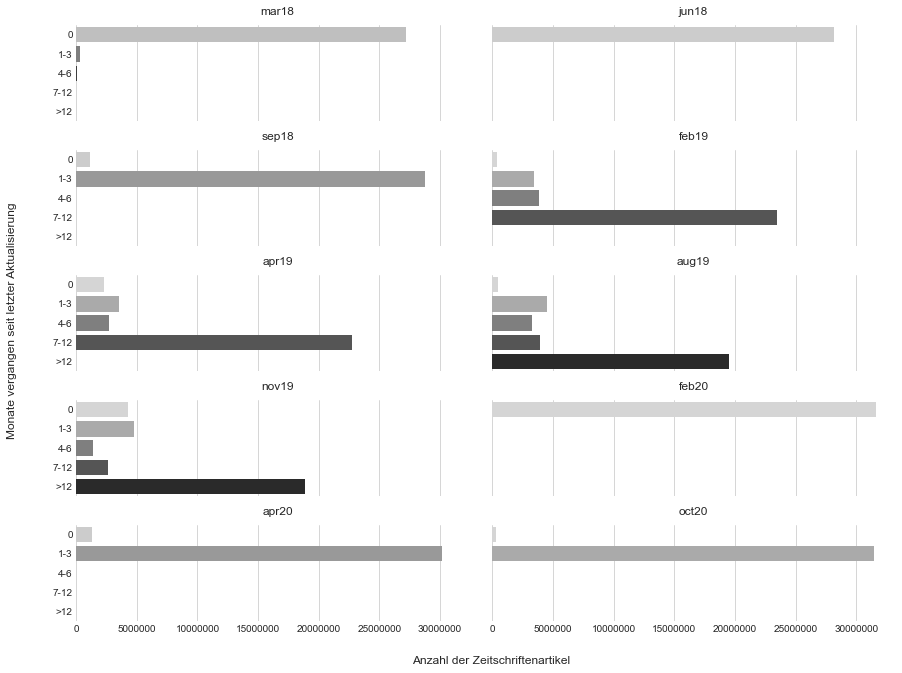

In [63]:
plt.style.use('seaborn-whitegrid')

fig, axes = plt.subplots(nrows=5, 
                         ncols=2, 
                         sharex=True, 
                         sharey=True, 
                         figsize=(12, 9))

axes = axes.reshape(-1)

#ti = fig.suptitle('Last Updated', 
#                  fontsize=15, 
#                  fontweight=600, 
#                  x=0.53,
#                  y=1.0)

snapshot_list = list(unpaywall_snapshots.keys())
snapshot_list.remove('apr18')

for i, ax in enumerate(axes, 1):
    
    snapshot = snapshot_list[i-1]
    
    df2 = df_months[df_months['snapshot']==snapshot]
    
    sns.barplot(data=df2, 
                x='n', 
                y='aggregated_months', 
                palette='binary',
                ax=ax)
    
    sns.despine(bottom = True, left = True)
    
    ax.set_ylabel('')    
    ax.set_xlabel('')
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
    
    ax.set_title(snapshot, fontdict={'fontsize': 12, 'fontweight': 500}, pad=10)
    
    ax.grid(False, which='both', axis='y')

# common xlabel   
x_label = fig.text(0.52, -0.03, 'Anzahl der Zeitschriftenartikel', ha='center', 
                   fontdict={'fontsize': 12, 'fontweight': 500})

# common ylabel
y_label = fig.text(-0.04, 0.5, 'Monate vergangen seit letzter Aktualisierung', va='center', rotation='vertical', 
                   fontdict={'fontsize': 12, 'fontweight': 500})

plt.tight_layout()

plt.show()

fig.savefig('media/updated_n.png', format='png',
            bbox_extra_artists=(x_label, y_label), bbox_inches='tight', dpi=500)

## Flipped Journals

https://support.unpaywall.org/support/solutions/articles/44001792752-how-do-we-decide-if-a-given-journal-is-fully-oa-

In [64]:
df_flipped = pd.DataFrame()

for snapshot in unpaywall_snapshots:
    if snapshot in ['feb20', 'apr20', 'oct20']: 
        is_paratext = 'AND is_paratext=false'
    else:
        is_paratext = ''
    for snapshot_name in unpaywall_snapshots[snapshot]:
        try:
            df2 = client.query(f"""
                               SELECT oa_status, COUNT(DISTINCT(journal_name)) AS jr, 
                                   COUNT(DISTINCT(doi)) AS n
                               FROM {snapshot_name}
                               WHERE year<2019 AND genre="journal-article"
                                 AND (oa_status="gold" OR oa_status="bronze" OR oa_status="hybrid")
                                 AND journal_is_oa=true AND journal_is_in_doaj=false {is_paratext}
                               GROUP BY oa_status
                               """).to_dataframe()

            df2['snapshot'] = snapshot

            df_flipped = df_flipped.append(df2, ignore_index=True)
        except:
            continue

In [65]:
df_flipped = df_flipped.groupby(['snapshot', 'oa_status']).sum().reset_index()

In [66]:
df_flipped

,snapshot,oa_status,jr,n
0,apr19,bronze,93,3853
1,apr19,gold,655,5697
2,apr19,hybrid,864,66191
3,apr20,bronze,1,8
4,apr20,gold,16742,1472768
5,apr20,hybrid,1,230
6,aug19,bronze,1,14
7,aug19,gold,1871,78559
8,aug19,hybrid,1,204
9,feb20,bronze,1,8


## Is paratext

In [67]:
df_paratext = pd.DataFrame()

for snapshot in unpaywall_snapshots:
    for snapshot_name in unpaywall_snapshots[snapshot]:
        try:
            df2 = client.query(f"""
                               SELECT COUNT(DISTINCT(doi)) AS n, oa_status, is_paratext
                               FROM {snapshot_name}
                               WHERE year<2019 AND genre="journal-article" AND is_paratext=True
                               GROUP BY is_paratext, oa_status
                               """).to_dataframe()

            df2['snapshot'] = snapshot

            df_paratext = df_paratext.append(df2, ignore_index=True)
        except:
            continue

In [68]:
df_paratext.groupby(['snapshot', 'is_paratext', 'oa_status'])['n'].sum().reset_index()

,snapshot,is_paratext,oa_status,n
0,apr20,True,bronze,51527
1,apr20,True,closed,220694
2,apr20,True,gold,7179
3,apr20,True,green,1054
4,apr20,True,hybrid,3599
5,feb20,True,bronze,51823
6,feb20,True,closed,217779
7,feb20,True,gold,7122
8,feb20,True,green,945
9,feb20,True,hybrid,6535
